# Clustering Companies by Financial Health Using JPMorgan Chase QuantChallenge 2023 Dataset

### Problem Statement

The dataset provided by JPMorgan Chase during the 2023 Quant Challenge, holds the financial data for multiple stocks over time, including metrics such as liabilities, equity, revenue, net income, and more. My goal for this project is to cluster companies based on their financial health and performance as reflected by their stock-level data. While the dataset is organized around individual stocks, the features reflect the financial condition of underlying companies. So in essense, I am using the stock's financial indicators provided by JPMC to group companies based on their performance to support investment analysis.

Clustering provides a way to carry out this objective without predefined labels. By preprocessing the data (normalizing continuous financial variables), I apply unsupervised learning models like K-Means and Hierarchical Clustering which are suited for breaking down financial data and helping investors/analysts understand financial strategies, risk profiles, and growth potential. The final output can guide more targeted and informed investment decisions.

In [439]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

### Step 1: Importing & Exploring Dataset

**What features does the dataset contain?** 

This dataset contains 12 features.
Date and Stock columns are categorical as they represent groups, not measurable quantities.
The rest of the features are continous as they are quantitative, numeric, and measurable.

Date -  Categorical                   
Stock - Categorical                   
Liabilities - Continous            
Equity - Continous                 
Total_assets - Continous           
Current_assets - Continous         
Current_liabilities - Continous    
Total_revenue - Continous          
Net_income - Continous             
Dividend - Continous               
Shares_outstanding - Continous     
Price - Continous    

**Any missing values, null values, how many unique values?**

This dataset has no missing values, null values, and no obvious outliers.

**What are the unique values?**

Date -                    150  
Stock            -        100  
liabilities     -       15000  
equity         -        15000  
total_assets    -       15000  
current_assets  -       15000  
current_liabilities   - 15000  
total_revenue      -    15000  
net_income       -      15000  
dividend        -        7599  
shares_outstanding  -   13869  
price               -   14901  

In [442]:
# Load dataset
training_set = pd.read_csv('Train.csv')
testing_set = pd.read_csv('Test_x.csv')

# First few rows
print('First Few Rows: ')
print(training_set.head())
print()

# Dataset information
print('Dataset Information: ')
print(training_set.info())
print()

# Summary statistics
print('Dataset Statistics: ')
print(training_set.describe(include='all'))
print()

# Unique values per column
print('Unique Values: ')
print(training_set.nunique())
print()

# Missing/null value check
print('Missing/Null Values: ')
print(training_set.isnull().sum())
print()


First Few Rows: 
         Date    Stock  liabilities      equity  total_assets  current_assets  \
0  2006-07-31  Stock 1   625.898686  925.086518   1550.985204      675.789905   
1  2006-08-31  Stock 1   407.387467  903.249093   1310.636561     1023.110983   
2  2006-09-29  Stock 1   464.069891  602.668832   1066.738722      709.711673   
3  2006-10-31  Stock 1   855.854937  391.375369   1247.230306      649.979564   
4  2006-11-30  Stock 1   453.954969  956.490566   1410.445534     1115.594551   

   current_liabilities  total_revenue  net_income   dividend  \
0           555.931329     548.488451  251.282553  68.184030   
1          1295.186240     513.446432  207.576940  42.232672   
2           598.719338     503.519871  133.719700  28.835722   
3           733.594339     596.006397  -76.881818   0.000000   
4          1152.274711     965.939247 -309.204301   0.000000   

   shares_outstanding       price  
0             1040831  100.000000  
1             1046649  101.924169  
2  

### Step 2: Data Exploration & Visualization

**Distribution Plot: Net Income**

Symmetrically distributed indicating no extreme bias toward profit or loss in the dataset.

**Box Plot: Revenue Distribution by Stock**

Consistent distribution of revenues across the stocks - indicates no single stock is an extreme performer in terms of revenue.

**Heatmap: Financial Features**

The financial structure (assets, liabilities, equity) is consistent. Income based metrics like net income or revenue aren’t strongly linked to other features.

**Scatter Plot: Liabilities vs Equity**

There’s not a strong correlation between liabilities and equity despite a positive correlation - likely due to variance/noise or interaction with others.

**Pairplot: Financial Features**

Assets-related features are dependent, which makes sense accounting wise. Net income behaves more independently.

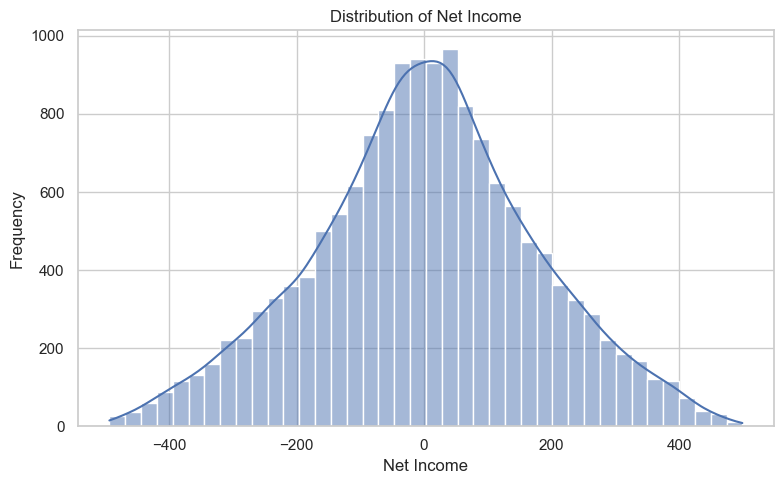

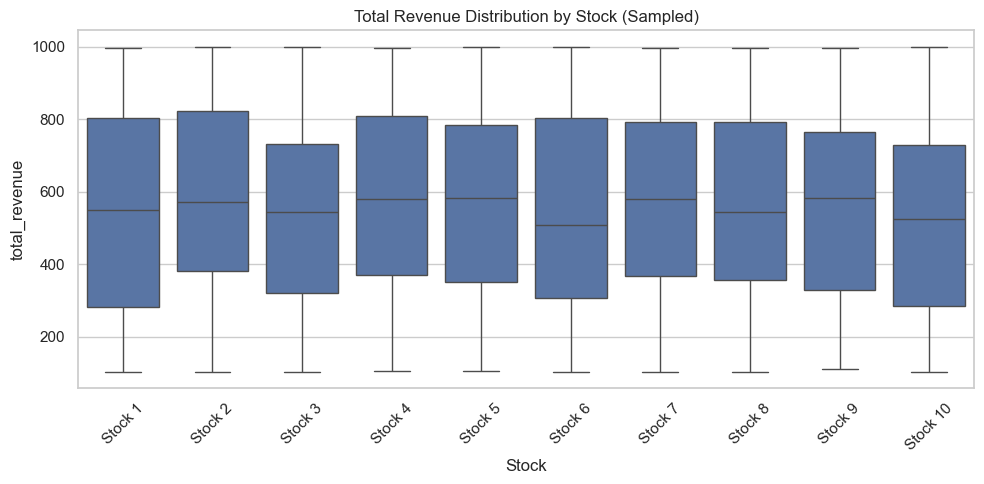

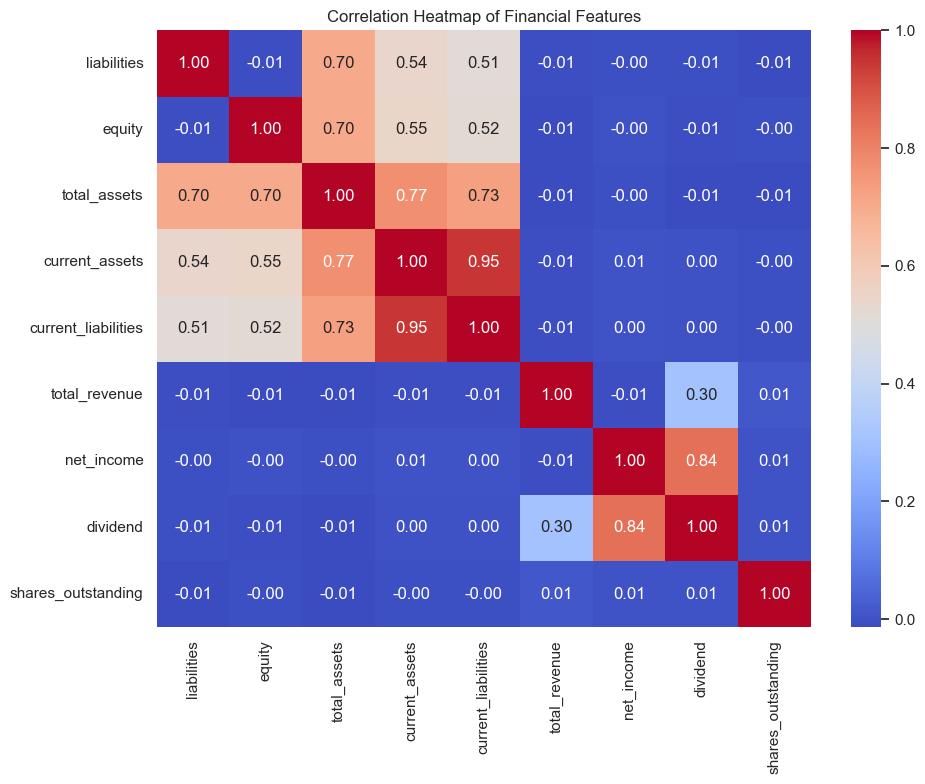

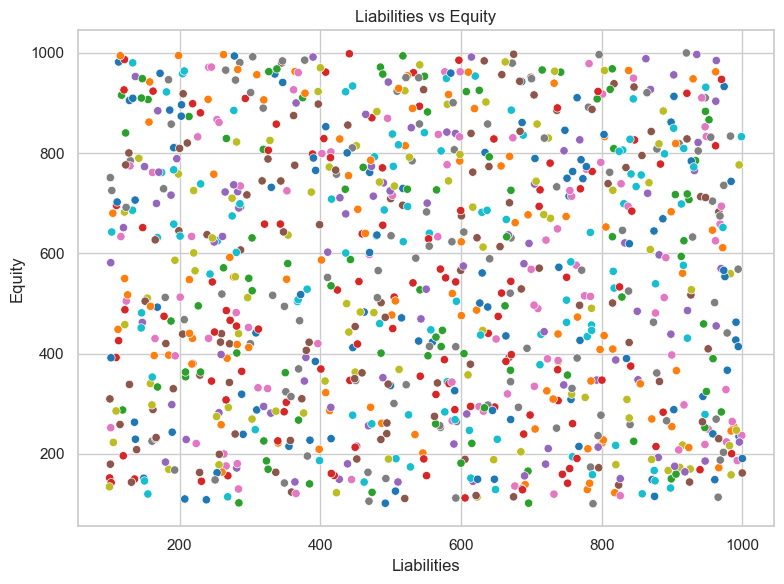

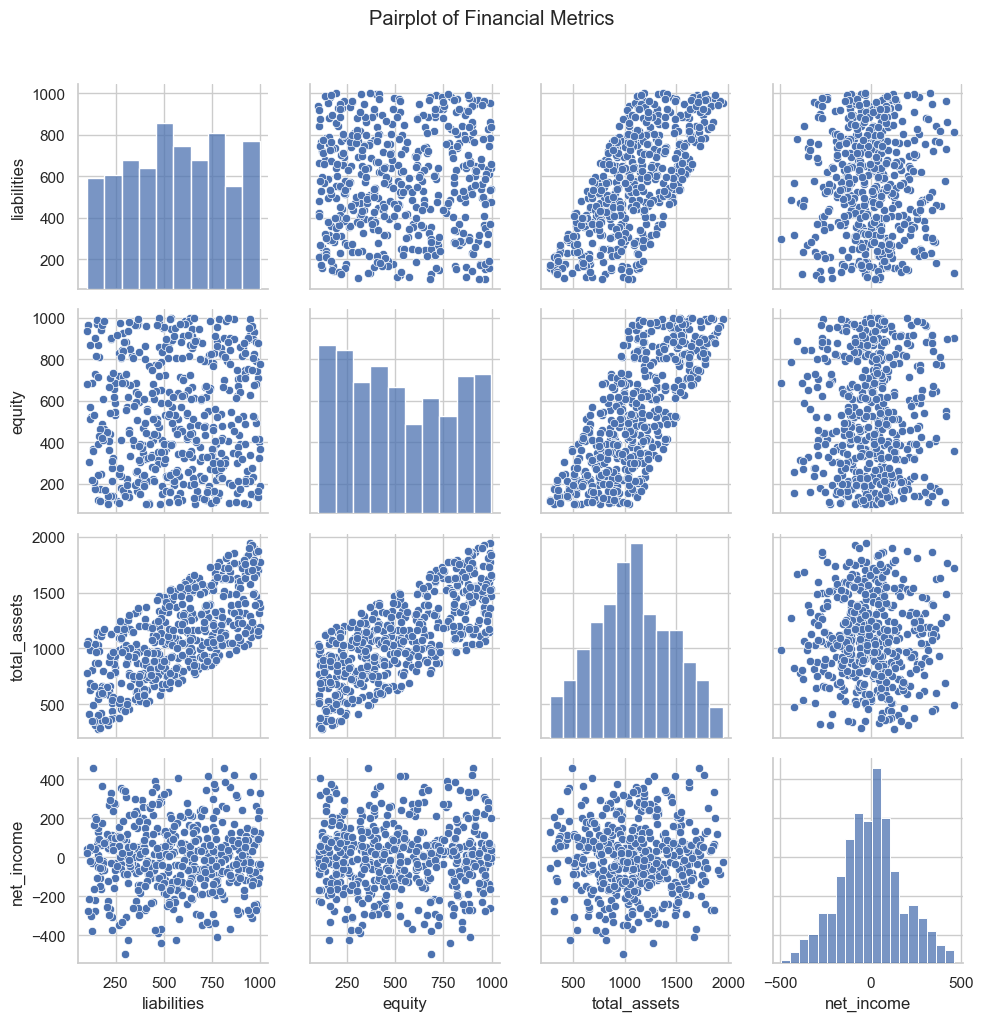

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Distribution Plot for Net Income
plt.figure(figsize=(8, 5))
sns.histplot(training_set['net_income'], kde=True, bins=40)
plt.title('Distribution of Net Income')
plt.xlabel('Net Income')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. Box Plot for Total Revenue by Stock (first 10 stocks only)
plt.figure(figsize=(10, 5))
sampled_stocks = training_set['Stock'].unique()[:10]
sns.boxplot(x='Stock', y='total_revenue', data=training_set[training_set['Stock'].isin(sampled_stocks)])
plt.title('Total Revenue Distribution by Stock (Sampled)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Heatmap of Feature Correlations (excluding price for now)
plt.figure(figsize=(10, 8))
numeric_cols = training_set.select_dtypes(include=['float64', 'int64']).drop(columns=['price'])
correlation = numeric_cols.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial Features')
plt.tight_layout()
plt.show()

# 4. Scatter Plot of Liabilities vs Equity (sample of 1000)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=training_set.sample(1000), x='liabilities', y='equity', hue='Stock', palette='tab10', legend=False)
plt.title('Liabilities vs Equity')
plt.xlabel('Liabilities')
plt.ylabel('Equity')
plt.tight_layout()
plt.show()

# 5. Pairplot of Selected Financial Features
selected_features = ['liabilities', 'equity', 'total_assets', 'net_income']
sns.pairplot(training_set[selected_features].sample(500))
plt.suptitle('Pairplot of Financial Metrics', y=1.02)
plt.tight_layout()
plt.show()


### Step 3a: Scaling

**What is scaling?**  

Adjusting the magnitude of data so one feature does not dominate over others, therefore preventing bias.

**Is it necessary to scale the data? What benefits would it provide?**

Yes it is necessary to scale the data when they vary to a greater extent (tens vs thousands vs millions). When you feed unscaled data into machine learning models, especially distance-based models like K-Means, the model gives more weight to larger features, even if they’re not important. This causes bias so scaling the data will re-create the features on a comparable scale to prevent domination and bias. After scaling, the model treats all features equally and will predict more accurately.

**Which scaler will you use for this data set? Min Max, Standard, Robust, etc.**

Standard Scaler is sufficient for this data set because the distribution is normal and we want to preserve the zero mean.  
This scales all numerical features to have a mean of 0 and standard deviation of 1.


**Are the features or the response variables scaled?**

Only the features should be scaled, not the response variable.

You can scale all numeric features — as long as:  
They are continuous/numerical.  
They are not your target/label.  
They are not already scaled or binary (0/1 indicators).

In [448]:
# Columns I want to scale - only numerical input features (excluding prices)
features = ['liabilities', 'equity', 'total_assets', 'current_assets',
            'current_liabilities', 'total_revenue', 'net_income',
            'dividend', 'shares_outstanding']

scaler = StandardScaler() # Selecting scaler
X_train_set_scaled = scaler.fit_transform(training_set[features]) # Applying transformation

### Step 3b: Data Preprocessing

**Data Preprocessing:** 

Cleaning, fixing, and transforming steps done before feeding the data into an algorithm (in this case, KMeans).  

**Common Preprocessing Steps:**
- Handling Missing values
- Scaling
- Encoding
- Removing Features
- Feature Selection
- Dimensionality Reduction (PCA)

**My reprocessing measures and why I chose them:**
- Scaling: I chose to scale my data using standard scaler to avoid bias and produce accurate clusters. I used standard scaler on numerical columns to preserve the mean as it already had a normal distribution.
- Feature Selection: I selected only the features that would cluster stocks based on their financial health and performance behavior to offer deeper knowledge into market behavior. Those features are liabilites, equity, total_assets, current_assets, current_liabilities, total_revenue, net_income, dividend, and shares_outstanding. I decided to not use the target variable for this dataset, price, as one should not scale the prediction.




### Step 4: Model Creation, Visualization, & Comparison

**Two models I chose and reason:**  
I chose KMeans and Hierarchical Clustering because they are widely used in unsupervised learning to group data based on similarity.    
 
**K-Means Clustering:**  
    Definition: K-Means partitions data into k clusters by minimizing the sum of squared distances between points and their assigned cluster’s center.  
    How it works: It randomly initializes cluster centers, assigns points to the nearest one, recalculates centers, and repeats until convergence.  
    Why it's useful: Fast and efficient for large datasets. Works best when clusters are spherical and of similar size.  
    Why I chose it: It’s simple, effective, and easy to visualize. Since financial data often forms distinct behavioral groups, K-Means is a great starting point.   

- Model Creation Steps:
1. Find Optimal K (AKA Optimal num of clusters) using Elbow Method:  
For KMeans, finding k is the first step. Elbow Method helps you find this sweet spot - the number of clusters where adding more doesn’t significantly improve performance. In this case, k=4. Then apply KMeans model with k=4.

2. Apply KMeans to the dataset using optimal K found by the elbow graph.

- *Performance:*   
Produced very clear, separated clusters in the PCA visualization.  
Had a higher silhouette score, meaning better groupings.  
Elbow method helped determine the best k.   

**Hierarchical Clustering**  
Definition: Builds a hierarchy of clusters by recursively merging the two closest clusters (bottom-up approach).  
How it works: Starts with each data point as its own cluster, merges the closest ones based on distance, and builds a dendrogram to show structure.  
Why it's useful: Doesn’t require specifying k in advance and can capture non-spherical relationships.  
Why I chose it: Helpful for understanding deeper relationships and natural groupings in the dataset, even if the shapes are complex.  

- Model Creation Steps:

1. Create Linkage Matrix using Ward's method.  
Ward's method minimizes variance and creates tight compact groups.  
Creates a matrix of distances between all data points.

2. Create Dendrogram.  
Visually shows how data points and clusters are merged step by step.  
At the bottom, each stock is its own cluster. As you go up, similar ones are merged.

3. Apply Hierarichal to the dataset.

- *Performance:*  
Captured more subtle overlaps between groups.  
More interpretable with the dendrogram, but less clean in visualization.  
Better for understanding relationships, but slightly lower performance in compactness.

**Comparison:**
Overall K-Means performed better for clean group separation.

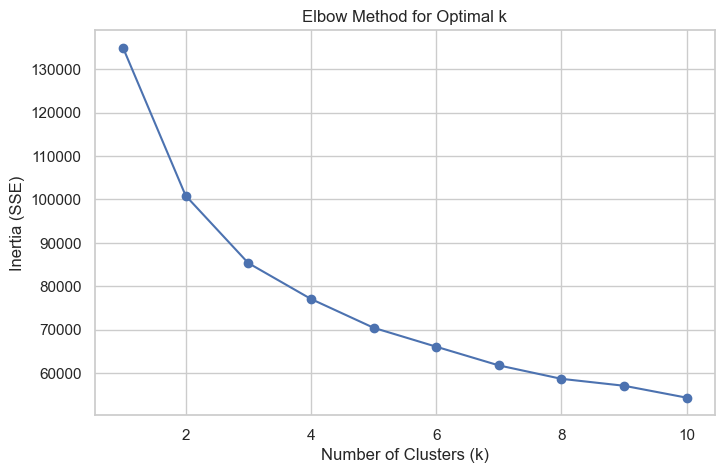

In [452]:
# KMeans

# Trying KMeans with 1 - 10 clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_set_scaled)
    inertia.append(kmeans.inertia_)

# Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# KMeans Application with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_train_set_scaled)
training_set['cluster'] = clusters



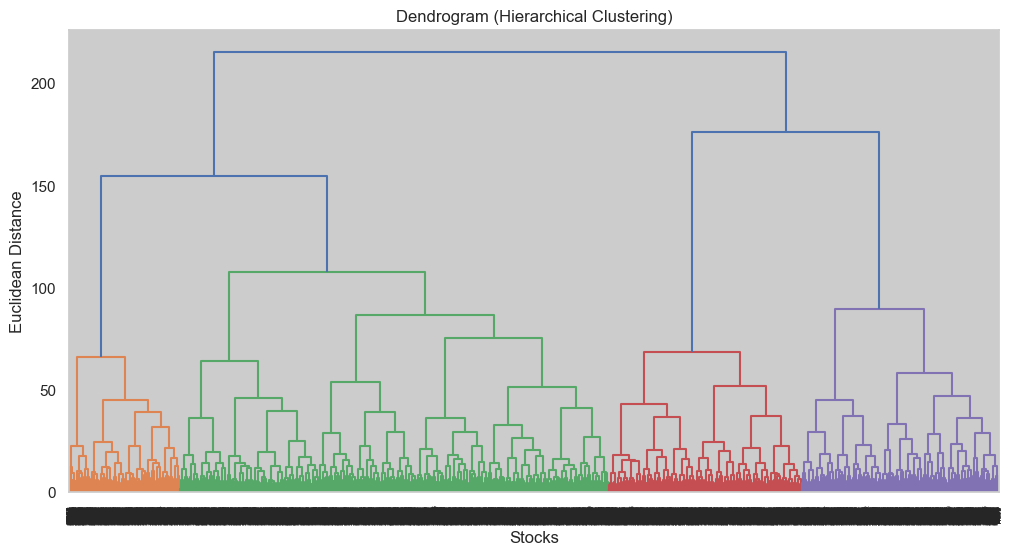

In [454]:
# Hierarchy

from sklearn.cluster import AgglomerativeClustering

# Create linkage matrix using Ward's method (minimizes variance)
linkage_matrix = sch.linkage(X_train_set_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram (Hierarchical Clustering)')
plt.xlabel('Stocks')
plt.ylabel('Euclidean Distance')
plt.show()

# Hierarchical Application
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hc_labels = hc.fit_predict(X_train_set_scaled)
training_set['hierarchical_cluster'] = hc_labels

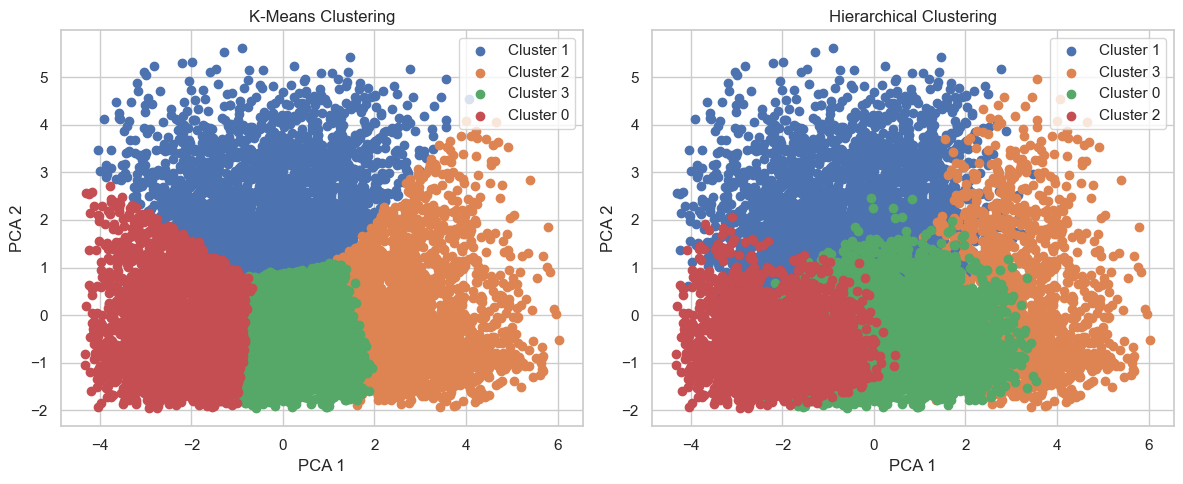

In [456]:
# Visualizing Graphs

from sklearn.decomposition import PCA

# Reduce to 2 dimensions with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_set_scaled)

# Add PCA coordinates to the DataFrame
training_set['pca1'] = X_pca[:, 0]
training_set['pca2'] = X_pca[:, 1]

# Plot K-Means Clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cluster in training_set['cluster'].unique():
    clustered_data = training_set[training_set['cluster'] == cluster]
    plt.scatter(clustered_data['pca1'], clustered_data['pca2'], label=f'Cluster {cluster}')
plt.title('K-Means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

# Plot Hierarchical Clusters
plt.subplot(1, 2, 2)
for cluster in training_set['hierarchical_cluster'].unique():
    clustered_data = training_set[training_set['hierarchical_cluster'] == cluster]
    plt.scatter(clustered_data['pca1'], clustered_data['pca2'], label=f'Cluster {cluster}')
plt.title('Hierarchical Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

plt.tight_layout()
plt.show()



### What do the PCA graphs mean?

*NOTE: I am not clustering features together — I am clustering rows - AKA stocks - based on the patterns found across the features.*

These graphs don’t tell you which features were used — they show how similar or different stocks are based on the features combined. Since clustering is unsupervised, the algorithm won’t say which features were most important directly. Unsupervised learning has no labels - meaning no direct outputs.

**For more context of these graphs, you pair this with:** 
- The cluster summaries (mean values)  
How each feature should be: base interpretation off the feature averages per company/stock  
liabilities: Low   
equity: High   
total_assets: High   
current_assets: High   
current_liabilities: Low   
total_revenue: High   
net_income: High   
dividend: High   
shares_outstanding: Moderate    
- The silhouette score  
- The business logic (e.g., “these clusters align with high/low profitability groups”)  

Since there are 4 clusters, it indicates that there are 4 major trends the stocks are organized by. This means that the stocks are grouped by 4 major patterns that define its financial behavior. Each color is a group of stocks with similar financial profiles & these 4 patterns can provide further details into its market performance. 

- The closer two points are = more similar their overall financial data  
- The more distinct a colored blob = the more different that group is from others

 

In [459]:
# 1. Cluster Summaries: Gives insight into "What kind of companies are in this cluster?"
training_set.groupby('cluster')[features].mean()
training_set.groupby('hierarchical_cluster')[features].mean()

,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,dividend,shares_outstanding
hierarchical_cluster,,,,,,,,,
0,605.043777,585.171609,1190.215386,633.855606,660.835718,494.261314,-67.335028,5.678993,1.047988e+06
1,492.572283,527.916273,1020.488555,534.621129,555.910062,717.134727,218.764025,55.129956,1.049094e+06
2,335.348976,343.553484,678.902460,343.458725,357.791344,524.039264,-74.223652,4.906725,1.054778e+06
3,791.277593,807.309345,1598.586937,1068.924726,1149.771700,535.376841,6.628353,17.351257,1.052632e+06


### Interpretation:    
*NOTE:* Assuming all features weigh equally   
Cluster 0 (Red): Performs Okay      
Cluster 1 (Blue): Performs Best  
Cluster 2 (Green): Performs Worst  
Cluster 3 (Orange): Performs Good

Best -> Worst: **Blue -> Orange -> Red -> Green**

### Cluster Characteristics

**This is because:**    
Cluster 0: 
- 2 high performing features (total_assets, shares_outstanding)
- 3 low performing features (liabilities, net_income, dividend)
- 4 moderate performing features (equity, current_assets, current_liabilities, total_revenue)  
*Compared to other clusters, this group performs okay.*  
**-> Below average performers — moderately sized, but struggling to generate profit.**
  
Cluster 1:  
- 5 high performing features (total_assets, total_revenue, net_income, dividend, shares_outstanding)  
- 1 low performing feature (current_assets)      
- 3 moderate performing features (liabilities, equity, current_liabilities)  
*Compared to other clusters, this group performs best because it has the most high performing features with the fewest low performing features.*  
**-> High-value cluster of profitable, well-performing companies.**

Cluster 2: 
- 3 high performing features (liabilities, current_liabilities, shares_outstanding)
- 5 low performing features (equity, total_assets, current_assets, net_income, dividend)
- 1 moderate performing feature (total_revenue)  
*Compared to other clusters, this group performs worst because it has the most lowest performing features.*  
**-> Smallest across assets, equity, etc.**

Cluster 3:   
- 4 high performing features (equity, total_assets, current_assets, shares_outstanding)
- 3 low performing features (liabilities, current_liabilities, net_income)
- 2 moderate performing features (total_revenue, dividend)  
*Compared to other clusters, this group performs good.*  
**-> Large-scale companies with low profitability, but not in trouble**


In [463]:
# 2. Silhouette Score (How "good" the clusters are)
from sklearn.metrics import silhouette_score

# K-Means Silhouette
kmeans_silhouette = silhouette_score(X_train_set_scaled, training_set['cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Hierarchical Silhouette
hc_silhouette = silhouette_score(X_train_set_scaled, training_set['hierarchical_cluster'])
print(f"Hierarchical Silhouette Score: {hc_silhouette}")


K-Means Silhouette Score: 0.1681088062988105
Hierarchical Silhouette Score: 0.12725926833984824


**What this means:**  
Both scores are below 0.25, which indicates the clusters are not very well-separated.  
But K-Means performed slightly better than Hierarchical Clustering (0.168 vs 0.127). This also visually matches the PCA plot: K-Means clusters looked more compact and distinct.

### Conclusion:  
In this project, I applied unsupervised learning techniques (KMeans and Hierarchical Clustering Algorithms) to cluster companies based on their financial data. Although the dataset was organized around stocks, these features reflect the financial behavior of the companies themselves.

Using K-Means and Hierarchical Clustering, I identified four distinct groups of companies, Each cluster represents different financial profiles — from high-performing firms with strong revenue and dividend payouts to lower-performing companies with negative net income and minimal returns. This grouping was validated using PCA visualizations, Cluster Summaries, and Silhouette Scores which revealed meaningful insights into company performance. They showed clear separation among clusters in K-Means and slightly more overlap in Hierarchical Clustering.

These clusters can serve as a foundation for further investment analysis, helping investors target companies that match specific financial strategies, risk levels, or growth potential as resulted by the three validation methods.